In [26]:
import os
from spacepy import pycdf
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [27]:
#reading in the CDF and printing the properties
flux_e1 = pycdf.CDF('wi_sfsps_3dp_20021019211017_20021019215953 (1).cdf')
print(flux_e1)

ENERGY: CDF_FLOAT [124, 7]
ENERGY_filled: CDF_FLOAT [124, 7]
Epoch: CDF_EPOCH [124]
FLUX: CDF_FLOAT [124, 7]
FLUX_SIMPLE: CDF_FLOAT [124, 7]
metavar0: CDF_CHAR*27 [7] NRV
metavar1: CDF_CHAR*24 [7] NRV


In [28]:
#calculating delays
#reading in the energies of the 7 channels
energies1=flux_e1['ENERGY'][1]
erest_energy=511000 #in eV
c=3*(10**8) #light speed
L_0=1.5*(10**11) #sun-earth distance in m
#Relativistic:
gamma=np.zeros(7)
v_rel=np.zeros(7)
t_rel=np.zeros(7)
for i in range(7):
    gamma[i]=energies1[i]/erest_energy+1 #calculating the Lorentz factor
    v_rel[i]=c*np.sqrt(1-1/(np.square(gamma[i]))) #calculating the velocity corresponding to each energy
    t_rel[i]=(L_0/v_rel[i])/60 #calculating the time travelled by the electron in minutes
#Classical:
m_e=9.11*(10**(-31))
v_cla=np.zeros(7)
t_cla=np.zeros(7)
for i in range(7):
    v_cla[i]=np.sqrt(2*energies1[i]*1.602*(10**(-19))/m_e) #calculating the classical velocities, need to change eV to J
    t_cla[i]=(L_0/v_cla[i])/60 #calculating the time travelled by the electron in minutes
    

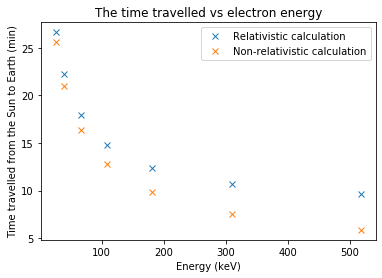

In [29]:
plt.plot(energies1/1000,t_rel,'x', label='Relativistic calculation')
plt.plot(energies1/1000,t_cla,'x', label='Non-relativistic calculation')
plt.title('The time travelled vs electron energy')
plt.ylabel('Time travelled from the Sun to Earth (min)')
plt.xlabel('Energy (keV)')
plt.legend()

In [56]:
#a bit overcomplicated calculation of arrival time
x=datetime.datetime(2002,10,19,21,6) #setting the time when the electrons started from the Sun
hourofarr=np.zeros(7)
minofarr=np.zeros(7)
timeofarr=np.zeros((7,2))
for i in range(7):
    arr_min=t_rel[i]+6
    if arr_min > 60: #if the electron travels for more than an hour
        hourofarr[i]=1 #add 1 to the hour value
        minofarr[i]=arr_min-60 #get the minutes above 1 hour
    else:
        hourofarr[i]=0 #otherwise leave the hour value
        minofarr[i]=arr_min
    timeofarr[i,:] = np.array([(hourofarr[i]+21), minofarr[i]])
timeofarr #displaying the arrival time

array([[21.        , 32.6421297 ],
       [21.        , 28.24372659],
       [21.        , 23.92410176],
       [21.        , 20.74341411],
       [21.        , 18.34143402],
       [21.        , 16.65107468],
       [21.        , 15.60443405]])

Text(0.5, 0, '2002 October')

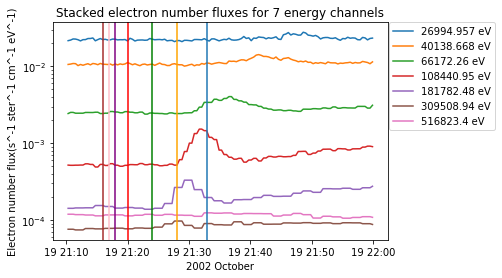

In [89]:
#plotting the fluxes as a stacked plot
for i in range(7):
    plt.plot(flux_e1['Epoch'],flux_e1['FLUX'][:,i], label=str(energies1[i])+' eV')
    plt.yscale('log')
    plt.legend(loc='upper right',borderaxespad=0,bbox_to_anchor=(1.32, 1))
plt.axvline(x=datetime.datetime(2002,10,19,21,33))
plt.axvline(x=datetime.datetime(2002,10,19,21,28),color='orange')
plt.axvline(x=datetime.datetime(2002,10,19,21,24),color='green')
plt.axvline(x=datetime.datetime(2002,10,19,21,20),color='red')
plt.axvline(x=datetime.datetime(2002,10,19,21,18),color='purple')
plt.axvline(x=datetime.datetime(2002,10,19,21,17),color='pink')
plt.axvline(x=datetime.datetime(2002,10,19,21,16),color='brown')
plt.title('Stacked electron number fluxes for 7 energy channels')
plt.ylabel('Electron number flux(s^-1 ster^-1 cm^-1 eV^-1)')
plt.xlabel('2002 October')

In [5]:
fluxes1=np.zeros(7)
background1=np.zeros(7)
for i in range(7):
    f=flux_e1['FLUX'][:,i] # the ith row of the flux
    f_corr=f[1:(len(f)-1)] # to get rid of the two [] symbols in the end (an error while reading in)
    fluxes1[i]=max(f_corr) # finding the maximum flux value number/(cm^2*ster*eV*s)
    background1[i]=np.average(f[0:30]) #calculating the average background before the event

In [6]:
# recall: energies1=flux_e1['ENERGY'][1] gives the 7 energy values, channels
energies1_keV= np.true_divide(energies1,1000) #changing eV to keV
fluxes1_corr=fluxes1-background1 #substracting the background

In [7]:
#finding the best fit for the log-log scale plot, source:https://stackoverflow.com/questions/43837179/best-fit-line-on-log-log-scales-in-python-2-7
m1, b1=np.polyfit(np.log(energies1_keV[0:4]), np.log(fluxes1_corr[0:4]), 1) #finding a linear fit to the log of energy vs log of flux
log_y_fit1 = m1*np.log(energies1_keV[0:4]) + b1 #from the obtained m, b values the log values of the best fit points are obtained
y_fit1 = np.exp(log_y_fit1) #taking the exponential of the log values
#redoing the whole thing for the second half of the vector as there is a break in the middle
m2, b2=np.polyfit(np.log(energies1_keV[3:7]), np.log(fluxes1_corr[3:7]), 1)
log_y_fit2 = m2*np.log(energies1_keV[3:7]) + b2
y_fit2 = np.exp(log_y_fit2)
print(m1)
print(m2)

-1.2735343168409468
-3.2028393786794602


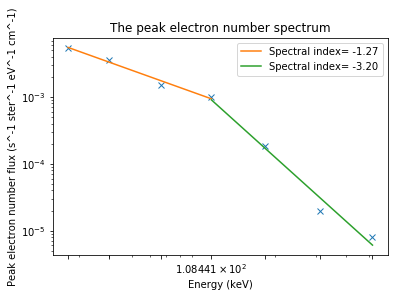

In [8]:
#plotting the peak number flux against the energies
plt.plot(energies1_keV,fluxes1_corr,'x')
#plotting the best fits
plt.plot(energies1_keV[0:4],y_fit1, label='Spectral index= -1.27')
plt.plot(energies1_keV[3:7],y_fit2, label='Spectral index= -3.20')
plt.yscale('log') #setting the log scales on the axes
plt.xscale('log')
plt.xticks(np.true_divide(energies1,1000))
plt.title('The peak electron number spectrum')
plt.ylabel('Peak electron number flux (s^-1 ster^-1 eV^-1 cm^-1)')
plt.xlabel('Energy (keV)')
plt.legend()